In [ ]:
import cv2
import zipfile
import numpy as np
 
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)



{'s1/1.pgm': array([[48, 49, 45, ..., 56, 56, 54],
       [45, 52, 39, ..., 52, 50, 51],
       [45, 50, 42, ..., 48, 53, 50],
       ...,
       [50, 48, 50, ..., 45, 46, 46],
       [45, 54, 49, ..., 46, 47, 47],
       [51, 51, 51, ..., 47, 46, 46]], dtype=uint8), 's1/10.pgm': array([[34, 34, 33, ...,  1,  1,  1],
       [35, 30, 32, ..., 38, 47, 39],
       [34, 28, 31, ..., 55, 59, 49],
       ...,
       [30, 29, 31, ..., 35, 37, 41],
       [31, 29, 32, ..., 42, 34, 39],
       [28, 33, 27, ..., 37, 40, 33]], dtype=uint8), 's1/2.pgm': array([[ 60,  60,  62, ...,  40,  53,  46],
       [ 58,  73,  54, ...,  34,  50,  51],
       [ 68,  77,  80, ...,  36,  50,  49],
       ...,
       [ 24, 143, 160, ...,  34,  33,  33],
       [ 18, 136, 161, ...,  36,  36,  31],
       [  9, 111, 168, ...,  32,  34,  34]], dtype=uint8), 's1/3.pgm': array([[39, 44, 53, ..., 47, 48, 47],
       [44, 44, 61, ..., 47, 45, 46],
       [59, 39, 57, ..., 46, 46, 44],
       ...,
       [49, 46, 42, ...

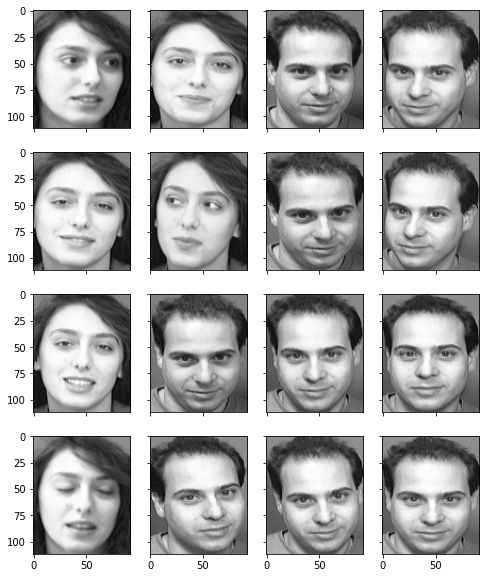

In [ ]:
import matplotlib.pyplot as plt
 
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

In [ ]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (112, 92)


In [ ]:
print(list(faces.keys())[:5])

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']


In [ ]:
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of pictures:", len(faces))

Number of classes: 40
Number of pictures: 400


In [ ]:
# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])
 
# Create facematrix as (n_samples,n_pixels) matrix
facematrix = np.array(facematrix)

In [ ]:
# Apply PCA to extract eigenfaces
from sklearn.decomposition import PCA
 
pca = PCA().fit(facematrix)

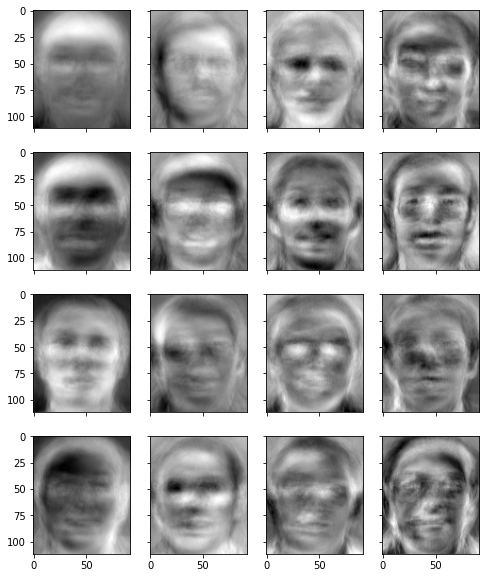

In [ ]:
# Take the first K principal components as eigenfaces
n_components = 50
eigenfaces = pca.components_[:n_components]
 
# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
plt.show()

In [ ]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
weights = eigenfaces @ (facematrix - pca.mean_).T

Best match s39 with Euclidean distance 1559.997137


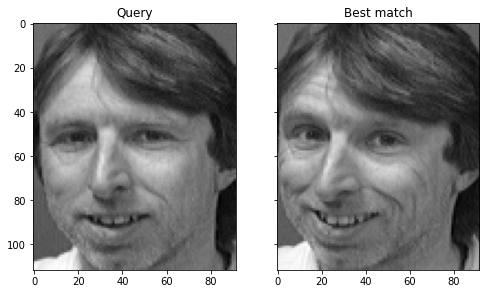

In [ ]:
# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Best match s5 with Euclidean distance 2690.209330


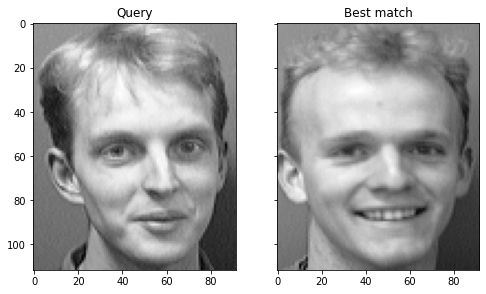

In [ ]:
# Test on out-of-sample image of new class
query = faces["s40/1.pgm"].reshape(1,-1)
#query_weight = eigenfaces @ (query - pca.mean_).T

query_weight = eigenfaces @ (query - pca.mean_).T
#print(query_weight.shape)
#print(weights.size)
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

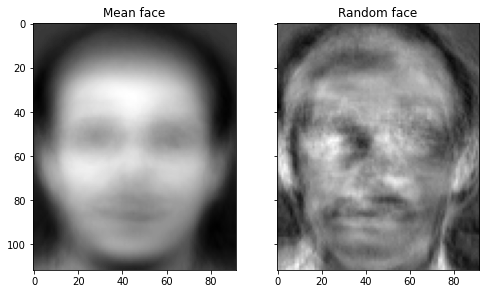

In [ ]:
# Visualize the mean face and random face
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(pca.mean_.reshape(faceshape), cmap="gray")
axes[0].set_title("Mean face")
random_weights = np.random.randn(n_components) * weights.std()
newface = random_weights @ eigenfaces + pca.mean_
axes[1].imshow(newface.reshape(faceshape), cmap="gray")
axes[1].set_title("Random face")
plt.show()